# Analyze Ball on Incline data
Use this notebook to quickly test whether your ball on incline data makes sense!

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

## Reading the data

The function "read_csv(filename)" takes in a filename and returns numpy arrays with time and voltage.

In [2]:
def read_csv(filename):
    """Read CSV from Waveforms"""
    dat = np.genfromtxt(filename, delimiter=',', skip_header=13, names=True)
    time = dat['Time_s']
    voltage = dat['Channel_1_V']
    return time, voltage

def find_midpoints(time, voltage, show_plot=True):
    """Find timing of ball crossings"""
    
    
    # Write a function yourself, which identifies the peaks in the voltage,
    # and returns values for passing times and (possibly) their uncertainties
    # in it (but they are generally very small!).

    time = np.array(time)
    voltage = np.array(voltage)

    threshold = 0.5 * (np.max(voltage) + np.min(voltage))

    # 2. Boolean mask: True while peak is high
    high = voltage > threshold

    # 3. Find rising and falling edges of the high regions
    edges = np.diff(high.astype(int))

    start_indices = np.where(edges == +1)[0] + 1   # rising edges
    end_indices   = np.where(edges == -1)[0]       # falling edges

    # Handle case where signal starts or ends high
    if high[0]:
        start_indices = np.insert(start_indices, 0, 0)
    if high[-1]:
        end_indices = np.append(end_indices, len(high)-1)

    # 4. Compute center times for each peak
    peak_centers = (time[start_indices] + time[end_indices]) / 2
   

    t_pass = np.array(peak_centers)
    t_pass_sigma = np.full_like(t_pass, 0.00001)    
    if show_plot:
        plt.plot(time, voltage, label='Voltage signal')
        plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
        plt.scatter(t_pass, np.full_like(t_pass, threshold), color='green', label='Detected Passings')
        plt.errorbar(t_pass, np.full_like(t_pass, threshold), yerr=t_pass_sigma, fmt='o', color='green')
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage (V)')
        plt.xlim(time[0], .6)
        plt.title('Ball on Incline Voltage Signal with Detected Passings')
        plt.legend()
        plt.show()
    


    
    return t_pass, t_pass_sigma

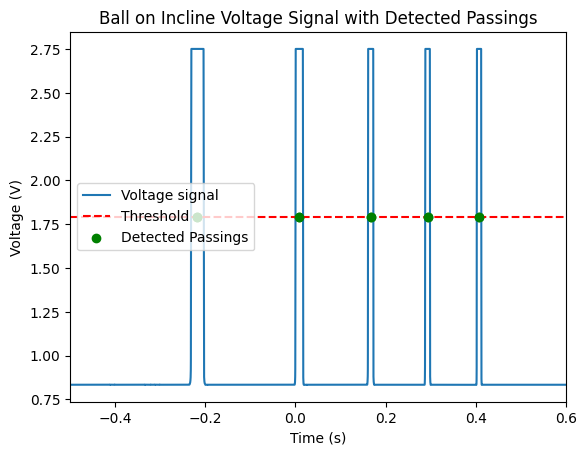

In [3]:
# Read the data and plot it (possibly with passing times in):
filename = 'ball_big_1.csv'

time, voltage = read_csv(filename)
timepass, timepass_sig = find_midpoints(time, voltage)

# fig, ax = plt.subplots(figsize=(14, 6))
# ax.plot(time, voltage, 'k.', label='Measurements')
# ax.set_title("Data from Ball-on-Incline experiment")
# ax.set_xlabel("Time (s)", fontsize=18)
# ax.set_ylabel("Voltage (V)", fontsize=18)


In [4]:
from iminuit import Minuit
from iminuit.cost import LeastSquares
import numpy as np
from scipy import stats

In [5]:
def model(t, a, v0):
    return 0.5 * a * t**2 + v0 * t
def fit(weighted_mean, weighted_mean_err, timepass):
  
    x = weighted_mean
    t = timepass - timepass[0]  # set t=0 at first passing

    sx = weighted_mean_err

    mfit = Minuit(LeastSquares(t, x, sx, model), a=9.81, v0=0.0)
    mfit.migrad()  # perform the minimization
    return mfit




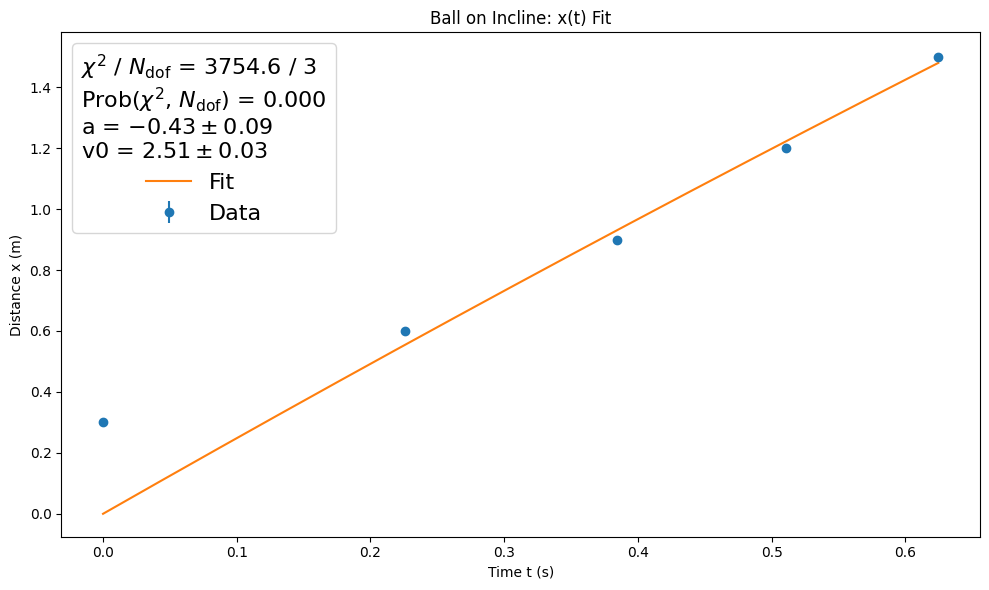

In [6]:
t = timepass - timepass[0]  # set t=0 at first passing
x = 0.3 * np.arange(1, len(t)+1)  # distances in m (30cm increments)
sx = np.full_like(x, 0.005)  # uncertainties in x (5mm)
mfit = fit(x, sx, timepass)

fig, ax = plt.subplots(figsize=(10, 6))

# Plot data with uncertainties in x
ax.errorbar(t, x, xerr=None, yerr=sx, fmt='o', label='Data')

ax.set(
    xlabel='Time t (s)',
    ylabel='Distance x (m)',
    title='Ball on Incline: x(t) Fit'
)

# Plot fit curve
t_fit = np.linspace(min(t), max(t), 1000)
x_fit = model(t_fit, *mfit.values)
ax.plot(t_fit, x_fit, '-', label='Fit')


# ------------------------------
# 4. CHI-SQUARE + p-value
# ------------------------------
chi2 = mfit.fval                          # χ² = cost function minimum value
Ndof = len(x) - len(mfit.values)          # number of degrees of freedom
p_value = stats.chi2.sf(chi2, Ndof)          # survival function

fit_info = [
    rf"$\chi^2$ / $N_\mathrm{{dof}}$ = {chi2:.1f} / {Ndof}",
    rf"Prob($\chi^2$, $N_\mathrm{{dof}}$) = {p_value:.3f}",
]

# Parameters + uncertainties
for p, v, e in zip(mfit.parameters, mfit.values, mfit.errors):
    Ndec = max(0, -int(np.log10(e) - 1 - np.log10(2)))
    fit_info.append(
        f"{p} = ${v:{10}.{Ndec}f} \\pm {e:{10}.{Ndec}f}$"
    )

plt.legend(title="\n".join(fit_info),
           fontsize=16,
           title_fontsize=16,
           alignment='center')

fig.tight_layout()
plt.show()

In [7]:
blinded = False          # Add a random (but fixed) offset to the 30cm and 2m data seperately

r = np.random             # Random generator
r.seed(42)                # Set a random seed (but a fixed one)



In [8]:
def weighted_mean(a,s):
    """Compute weighted mean and its uncertainty"""
    a = np.asarray(a, dtype=float)
    s = np.asarray(s, dtype=float)
    w = 1 / s**2
    wmean = np.sum(w * a) / np.sum(w)
    wmean_err = np.sqrt(1 / np.sum(w)) 
    return wmean, wmean_err

In [9]:
def main(filename):
    
        
        
    weighted_mean = np.array([8.45567020250723,23.390549662487942,38.54252651880424 ,53.46890067502411,69.1189006750241  ])*0.01
    weighted_mean_err = np.array([0.04347490658311758,0.04347490658311758,0.04347490658311758,0.04347490658311758,0.04347490658311758])*0.01
    time, voltage = read_csv(filename)
    timepass, timepass_sig = find_midpoints(time, voltage, show_plot=False)
    
    mfit = fit(weighted_mean, weighted_mean_err, timepass)
    return mfit

def process_files(file_list):
    """
    Runs main() for each file in file_list,
    returns arrays of a-values and a-errors.
    """
    a_vals = []
    a_errs = []
    for f in file_list:
        mfit = main(f)
        a_vals.append(mfit.values["a"])
        a_errs.append(mfit.errors["a"])
    return np.array(a_vals), np.array(a_errs)
def cross_check(a1, a1_err, a2, a2_err):
    diff = a1 - a2
    diff_err = np.sqrt(a1_err**2 + a2_err**2)
    z_score = diff / diff_err
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # two-tailed p-value
    return z_score, p_value

In [10]:
### FILES ###

big_ball_files = ['ball_big_1.csv', 'ball_big_2.csv', 'ball_big_3.csv', 'ball_big_4.csv', 'ball_big_5.csv', 'ball_big_6.csv', 'ball_big_7.csv', 'ball_big_8.csv']
big_ball_reversed_files = ['ball_big_reversed_1.csv', 'ball_big_reversed_2.csv', 'ball_big_reversed_3.csv', 'ball_big_reversed_4.csv', 'ball_big_reversed_5.csv']

med_balls_files = ['ball_med_1.csv', 'ball_med_2.csv', 'ball_med_3.csv', 'ball_med_4.csv', 'ball_med_5.csv']
med_balls_reversed_files = ['ball_med_reversed_1.csv', 'ball_med_reversed_2.csv', 'ball_med_reversed_3.csv', 'ball_med_reversed_4.csv', 'ball_med_reversed_5.csv']

small_balls_files = ['ball_small_1.csv', 'ball_small_2.csv', 'ball_small_3.csv', 'ball_small_4.csv', 'ball_small_5.csv']
small_balls_reversed_files = ['ball_small_reversed_1.csv', 'ball_small_reversed_2.csv', 'ball_small_reversed_3.csv', 'ball_small_reversed_4.csv', 'ball_small_reversed_5.csv']  

### PROCESSING ###

a_big, a_big_err = process_files(big_ball_files)
a_big_rev, a_big_rev_err = process_files(big_ball_reversed_files)

a_med, a_med_err = process_files(med_balls_files)
a_med_rev, a_med_rev_err = process_files(med_balls_reversed_files)

a_small, a_small_err = process_files(small_balls_files)
a_small_rev, a_small_rev_err = process_files(small_balls_reversed_files)

### WEIGHTED MEANS ###

a_big_wmean, a_big_wmean_err = weighted_mean(a_big, a_big_err)
a_big_rev_wmean, a_big_rev_wmean_err = weighted_mean(a_big_rev, a_big_rev_err)

a_med_wmean, a_med_wmean_err = weighted_mean(a_med, a_med_err)
a_med_rev_wmean, a_med_rev_wmean_err = weighted_mean(a_med_rev, a_med_rev_err)

a_small_wmean, a_small_wmean_err = weighted_mean(a_small, a_small_err)
a_small_rev_wmean, a_small_rev_wmean_err = weighted_mean(a_small_rev, a_small_rev_err)

### CROSS CHECK ###

# REVERSED VS NORMAL 
z_big, p_big = cross_check(a_big_wmean, a_big_wmean_err, a_big_rev_wmean, a_big_rev_wmean_err)
z_med, p_med = cross_check(a_med_wmean, a_med_wmean_err, a_med_rev_wmean, a_med_rev_wmean_err)
z_small, p_small = cross_check(a_small_wmean, a_small_wmean_err, a_small_rev_wmean, a_small_rev_wmean_err)
print("Big Ball vs Reversed: z =", z_big, ", p-value =", p_big)
print("Medium Ball vs Reversed: z =", z_med, ", p-value =", p_med)
print("Small Ball vs Reversed: z =", z_small, ", p-value =", p_small)

# BIG VS MEDIUM VS SMALL
z_big_med, p_big_med = cross_check(a_big_wmean, a_big_wmean_err, a_med_wmean, a_med_wmean_err)
z_big_small, p_big_small = cross_check(a_big_wmean, a_big_wmean_err, a_small_wmean, a_small_wmean_err)
z_med_small, p_med_small = cross_check(a_med_wmean, a_med_wmean_err, a_small_wmean, a_small_wmean_err)              
print("Big vs Medium: z =", z_big_med, ", p-value =", p_big_med)
print("Big vs Small: z =", z_big_small, ", p-value =", p_big_small)
print("Medium vs Small: z =", z_med_small, ", p-value =", p_med_small)







Big Ball vs Reversed: z = -0.7746477402071121 , p-value = 0.43854783927275953
Medium Ball vs Reversed: z = 2.509587271611248 , p-value = 0.012087234383624468
Small Ball vs Reversed: z = -2.175340898209079 , p-value = 0.029604579871214565
Big vs Medium: z = 2.6434801016083656 , p-value = 0.008205858871283445
Big vs Small: z = 17.55519085529324 , p-value = 0.0
Medium vs Small: z = 13.573215348775179 , p-value = 0.0


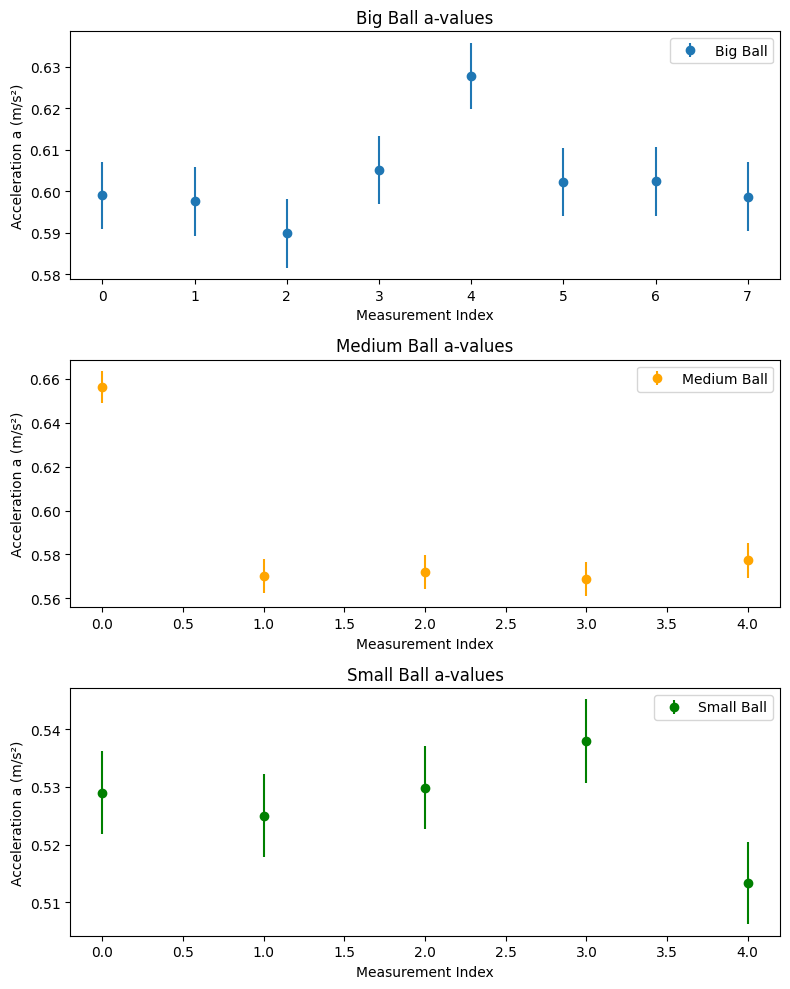

In [11]:

figs, axs = plt.subplots(3, 1, figsize=(8, 10))
axs[0].errorbar(range(len(a_big)), a_big, yerr=a_big_err, fmt='o', label='Big Ball')
axs[0].set_title('Big Ball a-values')
axs[1].errorbar(range(len(a_med)), a_med, yerr=a_med_err, fmt='o', label='Medium Ball', color='orange')
axs[1].set_title('Medium Ball a-values')
axs[2].errorbar(range(len(a_small)), a_small, yerr=a_small_err, fmt='o', label='Small Ball', color='green')
axs[2].set_title('Small Ball a-values')
for ax in axs:
    ax.set_xlabel('Measurement Index')
    ax.set_ylabel('Acceleration a (m/s²)')
    ax.legend()
plt.tight_layout()
plt.show()

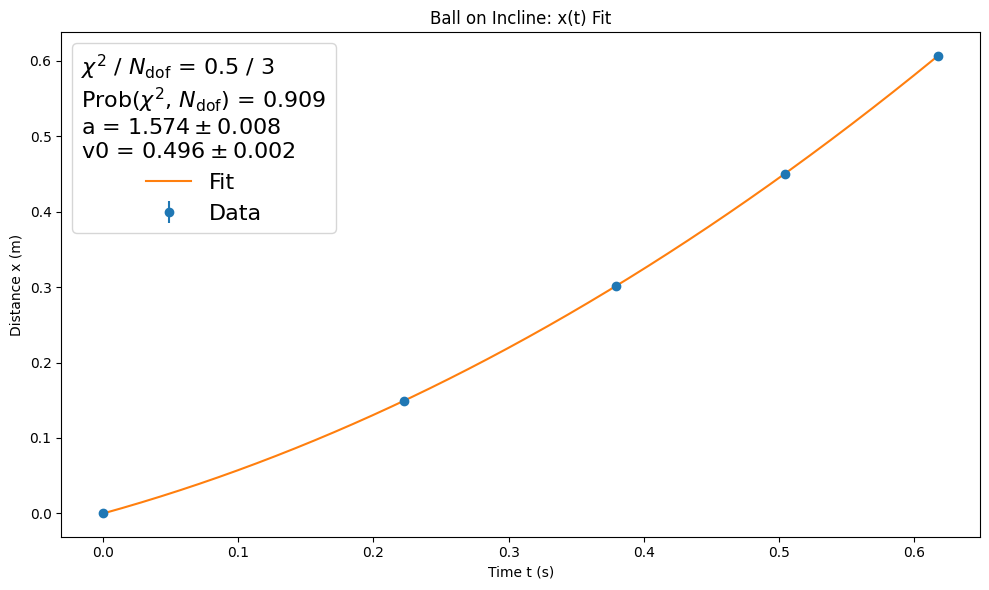

In [12]:
weighted_mean = np.array([8.45567020250723,23.390549662487942,38.54252651880424 ,53.46890067502411,69.1189006750241  ])*0.01
weighted_mean_err = np.array([0.04347490658311758,0.04347490658311758,0.04347490658311758,0.04347490658311758,0.04347490658311758])*0.01

time, voltage = read_csv('ball_big_3.csv')
timepass, timepass_sig = find_midpoints(time, voltage, show_plot=False)

t = timepass - timepass[0]  # set t=0 at first passing
x = weighted_mean - weighted_mean[0]
sx =weighted_mean_err
mfit = fit(x, sx, timepass)

fig, ax = plt.subplots(figsize=(10, 6))

# Plot data with uncertainties in x
ax.errorbar(t, x, xerr=None, yerr=sx, fmt='o', label='Data')

ax.set(
    xlabel='Time t (s)',
    ylabel='Distance x (m)',
    title='Ball on Incline: x(t) Fit'
)

# Plot fit curve
t_fit = np.linspace(min(t), max(t), 1000)
x_fit = model(t_fit, *mfit.values)
ax.plot(t_fit, x_fit, '-', label='Fit')


# ------------------------------
# 4. CHI-SQUARE + p-value
# ------------------------------
chi2 = mfit.fval                          # χ² = cost function minimum value
Ndof = len(x) - len(mfit.values)          # number of degrees of freedom
p_value = stats.chi2.sf(chi2, Ndof)          # survival function

fit_info = [
    rf"$\chi^2$ / $N_\mathrm{{dof}}$ = {chi2:.1f} / {Ndof}",
    rf"Prob($\chi^2$, $N_\mathrm{{dof}}$) = {p_value:.3f}",
]

# Parameters + uncertainties
for p, v, e in zip(mfit.parameters, mfit.values, mfit.errors):
    Ndec = max(0, -int(np.log10(e) - 1 - np.log10(2)))
    fit_info.append(
        f"{p} = ${v:{10}.{Ndec}f} \\pm {e:{10}.{Ndec}f}$"
    )

plt.legend(title="\n".join(fit_info),
           fontsize=16,
           title_fontsize=16,
           alignment='center')

fig.tight_layout()
plt.show()

So weird things happen here with ball size vs the reversed. If there was some angle inherent in the system, we would expect that the deviation would go in the same direction, but here it seems to go both ways. This could be explained by the uncertainties being a bit to small, thus inflating the sigmas, and then it might just be slight deviations where the angle is close to 0. then the big ball is a lot closer to its reversed, dont know why. 

In [13]:
# print all a

print("Big Ball a values:", a_big_wmean,a_big_wmean_err)
print("Medium Ball a values:", a_med_wmean,a_med_wmean_err)
print("Small Ball a values:", a_small_wmean,a_small_wmean_err)
print("Big Ball Reversed a values:", a_big_rev_wmean,a_big_rev_wmean_err)
print("Medium Ball Reversed a values:", a_med_rev_wmean,a_med_rev_wmean_err)
print("Small Ball Reversed a values:", a_small_rev_wmean,a_small_rev_wmean_err)



Big Ball a values: 0.603037590303122 0.002896084696554254
Medium Ball a values: 0.5911160503250329 0.0034570071976962173
Small Ball a values: 0.5269475813730009 0.003224766524777252
Big Ball Reversed a values: 0.6066598963074536 0.00367128197608857
Medium Ball Reversed a values: 0.5787745853007121 0.003497590577228099
Small Ball Reversed a values: 0.5368154905186545 0.0031903799380026306


In [18]:
### COMBINE RESULTS ###
a_combined = np.array([a_big_wmean, a_med_wmean, a_small_wmean,
                       a_big_rev_wmean, a_med_rev_wmean, a_small_rev_wmean])

a_combined_err = np.array([a_big_wmean_err, a_med_wmean_err, a_small_wmean_err,
                           a_big_rev_wmean_err, a_med_rev_wmean_err, a_small_rev_wmean_err])
                           
a, a_err = weighted_mean(a_combined, a_combined_err)

if blinded:
    a_final = a + r.normal(0, 0.2)
else:
    a_final = a

print("Final combined a =", a_final, "±", a_err)

TypeError: 'numpy.ndarray' object is not callable

In [ ]:

# a_values_big_ball = []
# a_errors_big_ball = []
# for file in big_ball_files:
#     mfit = main(file)
#     a = mfit.values["a"]
#     a_err = mfit.errors["a"]
#     a_values_big_ball.append(a)
#     a_errors_big_ball.append(a_err)
# #     print(f"{file}: a={a}")
# #     print(f"{file}: a_err={a_err}")


# a, a_err = weighted_mean(a_values_big_ball, a_errors_big_ball)
# if blinded:
#         a_final = a +r.normal(0, 0.2)

# else:
#         a_final = a
# print(f'Big ball weighted mean a: {a_final} ± {a_err}')

# if blinded:
#         a_final = a +r.normal(0, 0.05, size=timepass.shape)
# else:
#         a_final = a
# print(f'{a_final}')

# What to do next?

From the V(t) data you should be able to determine five times at which the ball passed. Discuss in the group how to do this best, and possibly test it by seeing if the result is "invariant" between different data sets.

Note that getting an uncertainty can be hard, and think about the relevance of such an uncertainty, which should anyway be rather small.